# Piecewise Training for Semantic Segmentation - Complete Pipeline
This notebook demonstrates:
1. Download and prepare VOC 2012 dataset
2. Install dependencies
3. Configure dataset paths
4. Visualize samples
5. Train the piecewise segmentation model
6. Generate comprehensive evaluation reports
7. Run inference on test images

## 1. Install Dependencies
Run the following cell to install required packages.

In [ ]:
%pip install torch torchvision numpy pillow matplotlib tqdm pandas tabulate seaborn 

## 2. Download VOC 2012 Dataset
Download from [VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) and extract it.
Expected structure:
```
VOCdevkit/VOC2012/
  ├── JPEGImages/
  ├── SegmentationClass/
  ├── ImageSets/Segmentation/
```

In [1]:
import kagglehub
huanghanchina_pascal_voc_2012_path = kagglehub.dataset_download('huanghanchina/pascal-voc-2012')

print('Data source import complete.')


c:\Users\rkekanaje\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 3.63G/3.63G [15:36<00:00, 4.16MB/s] 

Extracting files...


Data source import complete.


## 3. Configure Dataset Paths
Update the paths below to point to your VOC2012 dataset.

In [ ]:
import os

#huanghanchina_pascal_voc_2012_path="C:\\Users\\rkekanaje\\.cache\\kagglehub\\datasets\\huanghanchina\\pascal-voc-2012\\versions\\1"
# After kagglehub download
base_path = huanghanchina_pascal_voc_2012_path
print(f"Dataset downloaded to: {base_path}")

# Configure paths
image_dir = os.path.join(base_path,  'VOC2012', 'JPEGImages')
label_dir = os.path.join(base_path,  'VOC2012', 'SegmentationClass')
train_list = os.path.join(base_path,  'VOC2012', 'ImageSets', 'Segmentation', 'train.txt')
val_list = os.path.join(base_path,  'VOC2012', 'ImageSets', 'Segmentation', 'val.txt')

# Verify paths exist
assert os.path.exists(image_dir), f"Image directory not found: {image_dir}"
assert os.path.exists(label_dir), f"Label directory not found: {label_dir}"
print(f"✅ Image directory: {image_dir}")
print(f"✅ Label directory: {label_dir}")

# Check dataset statistics
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
label_files = [f for f in os.listdir(label_dir) if f.endswith('.png')]
print(f"\n📊 Dataset Statistics:")
print(f"   Total images: {len(image_files)}")
print(f"   Labeled images: {len(label_files)}")

Dataset downloaded to: C:\Users\rkekanaje\.cache\kagglehub\datasets\huanghanchina\pascal-voc-2012\versions\1
✅ Image directory: C:\Users\rkekanaje\.cache\kagglehub\datasets\huanghanchina\pascal-voc-2012\versions\1\VOC2012\JPEGImages
✅ Label directory: C:\Users\rkekanaje\.cache\kagglehub\datasets\huanghanchina\pascal-voc-2012\versions\1\VOC2012\SegmentationClass

📊 Dataset Statistics:
   Total images: 17125
   Labeled images: 2913


In [6]:
# Device configuration
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [10]:
# ========================================
# TEST CRF IMPLEMENTATION
# ========================================
print("\n" + "="*70)
print("TESTING CRF IMPLEMENTATION")
print("="*70)

import torch
from src.piecewise_training.model import DenseCRF

# Test with different batch sizes
test_cases = [
    (1, 21, 64, 64),   # Single image
    (4, 21, 64, 64),   # Small batch
    (8, 21, 64, 64),   # Training batch size
]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")
crf = DenseCRF(num_classes=21, num_iterations=5).to(device)

for batch_size, num_classes, h, w in test_cases:
    print(f"\nTesting: batch_size={batch_size}, classes={num_classes}, size={h}x{w}")
    
    unary = torch.randn(batch_size, num_classes, h, w).to(device)
    image = torch.randn(batch_size, 3, h, w).to(device)
    
    try:
        output = crf(unary, image)
        assert output.shape == unary.shape, f"Shape mismatch! Expected {unary.shape}, got {output.shape}"
        assert torch.allclose(output.sum(dim=1), torch.ones(batch_size, h, w).to(device), atol=1e-5), "Not a valid probability distribution!"
        print(f"   ✅ PASSED - Output shape: {output.shape}")
    except Exception as e:
        print(f"   ❌ FAILED - Error: {e}")
        raise

print("\n" + "="*70)
print("✅ ALL CRF TESTS PASSED!")
print("="*70)


TESTING CRF IMPLEMENTATION
Using device: cuda


Testing: batch_size=1, classes=21, size=64x64
   ✅ PASSED - Output shape: torch.Size([1, 21, 64, 64])

Testing: batch_size=4, classes=21, size=64x64
   ✅ PASSED - Output shape: torch.Size([4, 21, 64, 64])

Testing: batch_size=8, classes=21, size=64x64
   ✅ PASSED - Output shape: torch.Size([8, 21, 64, 64])

✅ ALL CRF TESTS PASSED!


In [11]:
# Pascal VOC class names
PASCAL_VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
    'sofa', 'train', 'tvmonitor'
]

# Device configuration

## 4. Visualize a Sample Image and Label

Found 2913 images with segmentation labels


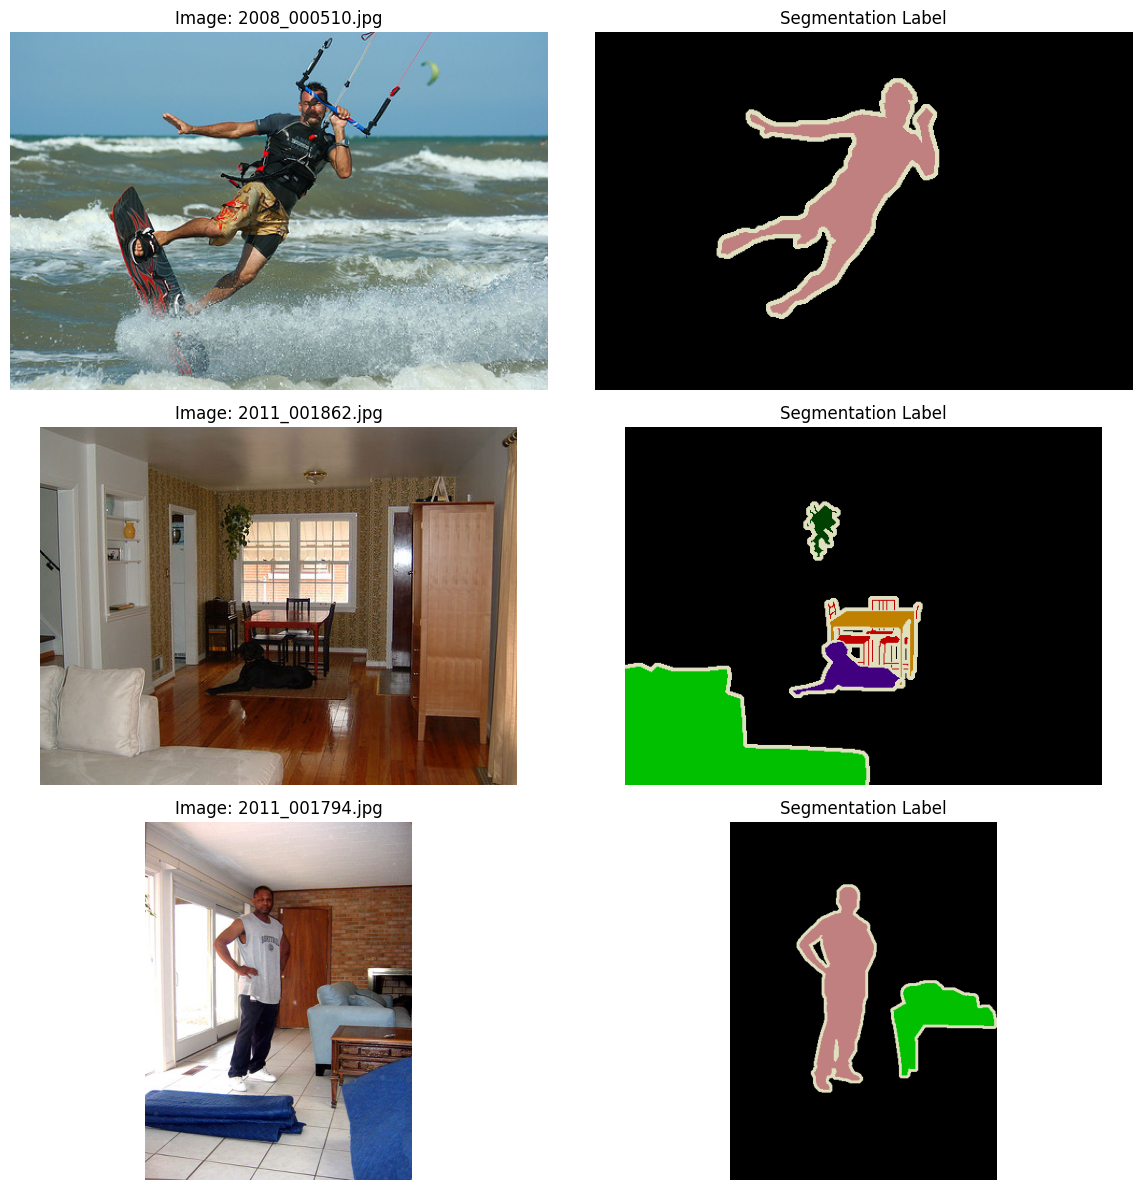

In [12]:

## 4. Visualize a Sample Image and Label

from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import os

def visualize_voc_samples(num_samples=3):
    """Visualize random samples from VOC dataset."""
    
    # Check if directories exist
    if not os.path.exists(image_dir):
        print(f"❌ Error: Image directory not found: {image_dir}")
        return
    
    if not os.path.exists(label_dir):
        print(f"❌ Error: Label directory not found: {label_dir}")
        return
    
    # Get list of LABEL files (these are the images with annotations)
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.png')]
    
    if len(label_files) == 0:
        print(f"❌ Error: No .png label files found in {label_dir}")
        return
    
    print(f"Found {len(label_files)} images with segmentation labels")
    
    if len(label_files) < num_samples:
        print(f"⚠️ Warning: Only {len(label_files)} labeled images available")
        num_samples = len(label_files)
    
    # Sample from labeled images
    sample_labels = random.sample(label_files, num_samples)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, label_name in enumerate(sample_labels):
        # Construct paths
        label_path = os.path.join(label_dir, label_name)
        img_name = label_name.replace('.png', '.jpg')
        img_path = os.path.join(image_dir, img_name)
        
        # Check if image exists
        if not os.path.exists(img_path):
            print(f"⚠️ Warning: Image not found for {label_name}")
            continue
        
        # Load image and label
        img = Image.open(img_path)
        label = Image.open(label_path)
        
        # Display
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f'Image: {img_name}')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(label, cmap='tab20', vmin=0, vmax=20)
        axes[idx, 1].set_title('Segmentation Label')
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_voc_samples(num_samples=3)

## 5. Train the Piecewise Model
This uses the implementation from `Efficient Piecewise Training of Deep Structured Models for Semantic Segmentation` (model, trainer, dataset classes).

In [13]:
# Import required modules
from src.piecewise_training.model import PiecewiseTrainedModel
from src.piecewise_training.trainer import PiecewiseTrainer
from src.piecewise_training.dataset import SegmentationDataset, RandomHorizontalFlip
from torch.utils.data import DataLoader, random_split

# Configuration
num_classes = 21
batch_size = 8
num_workers = 4 if torch.cuda.is_available() else 0  # ✅ ADDED: CPU-safe workers

print("Creating datasets...")

# Create full dataset
full_dataset = SegmentationDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    transform=RandomHorizontalFlip(p=0.5),  # ✅ ADDED: explicit probability
    image_size=(512, 512)
)

print(f"Total dataset size: {len(full_dataset)}")

# Split 80/20 for train/val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,  
    pin_memory=True if torch.cuda.is_available() else False  
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✅ Training batches: {len(train_loader)}")
print(f"✅ Validation batches: {len(val_loader)}")

# Test dataset loading
print("\nTesting dataset loading...")
img, label = full_dataset[0]
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")
print(f"Label unique values: {torch.unique(label)}")
print(f"Image range: [{img.min():.3f}, {img.max():.3f}]")
print("✅ Dataset loading test passed!")

print("\nCreating model and trainer...")

model = PiecewiseTrainedModel(
    num_classes=num_classes,
    crf_iterations=10,
    use_crf=True
)

trainer = PiecewiseTrainer(
    model=model,
    device=device,
    num_classes=num_classes,
    learning_rate=1e-3,
    weight_decay=5e-4
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model created!")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")


Creating datasets...
Loaded 2913 images with segmentation labels
Total dataset size: 2913
Training samples: 2330
Validation samples: 583
✅ Training batches: 292
✅ Validation batches: 73

Testing dataset loading...
Image shape: torch.Size([3, 512, 512])
Label shape: torch.Size([512, 512])
Label unique values: tensor([  0,   1,  15, 255])
Image range: [-2.118, 2.640]
✅ Dataset loading test passed!

Creating model and trainer...
✅ Model created!
   Total parameters: 20,505,872
   Trainable parameters: 20,505,872


## 6. Train the Piecewise Model

In [14]:
print("\n" + "="*70)
print("STARTING PIECEWISE TRAINING")
print("="*70)

# Train with piecewise strategy
history = trainer.train_piecewise(
    train_loader=train_loader,
    stage1_epochs=1,  # Train unary network (CHANGE TO 20 FOR FINAL TRAINING)
    stage2_epochs=1,   # Train CRF parameters (CHANGE TO 5)
    stage3_epochs=1,  # Joint fine-tuning (CHANGE TO 10)
    val_loader=val_loader
)

# Save model
model_save_path = 'piecewise_model_final.pth'
torch.save(model.state_dict(), model_save_path)
print(f"\n✅ Model saved to: {model_save_path}")


STARTING PIECEWISE TRAINING
Stage 1: Training Unary Network


Epoch 1/1: 100%|██████████| 292/292 [02:32<00:00,  1.92it/s, loss=0.667]


Epoch 1: Train Loss=2.1482, Val Loss=1.4038, Val mIoU=0.0348

Stage 2: Training CRF Parameters


Epoch 1/1: 100%|██████████| 292/292 [12:59<00:00,  2.67s/it, loss=2.43]


Epoch 1: Train Loss=2.5823, Val Loss=2.5707, Val mIoU=0.0348

Stage 3: Joint Fine-tuning


Epoch 1/1: 100%|██████████| 292/292 [57:09<00:00, 11.75s/it, loss=1.68]


Epoch 1: Train Loss=1.9837, Val Loss=2.5665, Val mIoU=0.0348

✅ Model saved to: piecewise_model_final.pth


## 7. Generate Comprehensive Evaluation Report

In [15]:
from pathlib import Path

print("\n" + "="*70)
print("GENERATING COMPREHENSIVE EVALUATION REPORT")
print("="*70)

from src.piecewise_training.visualization import ComprehensiveVisualizer
import numpy as np

# Create visualizer
visualizer = ComprehensiveVisualizer(
    num_classes=num_classes,
    class_names=PASCAL_VOC_CLASSES
)

# Collect validation metrics
print("\n📊 Collecting validation metrics...")
model.eval()

confusion_matrix = np.zeros((num_classes, num_classes))
sample_predictions = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Get predictions
        unary_output, crf_output = model(images, apply_crf=True)
        unary_pred = unary_output.argmax(1)
        crf_pred = crf_output.argmax(1) if crf_output is not None else unary_pred
        
        # Update confusion matrix
        for i in range(num_classes):
            for j in range(num_classes):
                mask = labels != 255  # Ignore index
                confusion_matrix[i, j] += (
                    (labels[mask] == i) & (crf_pred[mask] == j)
                ).sum().item()
        
        # Collect sample predictions (first 10 batches)
        if batch_idx < 10:
            for b in range(min(3, images.shape[0])):
                sample_predictions.append({
                    'image': images[b].cpu(),      
                    'gt': labels[b].cpu(),
                    'unary_pred': unary_pred[b].cpu(),
                    'crf_pred': crf_pred[b].cpu(),    
                    'pred': crf_pred[b].cpu()           
                })
        
        if batch_idx % 10 == 0:
            print(f"   Processed {batch_idx}/{len(val_loader)} batches...")

# Compute final metrics
print("\n📈 Computing final metrics...")
iou_per_class = visualizer._compute_iou_from_cm(confusion_matrix)
mean_iou = np.nanmean(iou_per_class)

final_metrics = {
    'mIoU': mean_iou,
    'Pixel Acc': confusion_matrix.diagonal().sum() / confusion_matrix.sum()
}

print(f"\n✅ Final mIoU: {mean_iou:.4f}")
print(f"✅ Pixel Accuracy: {final_metrics['Pixel Acc']:.4f}")

# Generate complete report
print("\n🎨 Generating visualizations...")
results_dir = 'training_results'
Path(results_dir).mkdir(parents=True, exist_ok=True)

visualizer.generate_full_report(
    history=history,
    final_metrics=final_metrics,
    confusion_matrix=confusion_matrix,
    sample_predictions=sample_predictions,
    save_dir=results_dir
)

print(f"\n✅ Complete report saved to: {results_dir}/")


GENERATING COMPREHENSIVE EVALUATION REPORT

📊 Collecting validation metrics...
   Processed 0/73 batches...
   Processed 10/73 batches...
   Processed 20/73 batches...
   Processed 30/73 batches...
   Processed 40/73 batches...
   Processed 50/73 batches...
   Processed 60/73 batches...
   Processed 70/73 batches...

📈 Computing final metrics...

✅ Final mIoU: 0.0348
✅ Pixel Accuracy: 0.7318

🎨 Generating visualizations...

GENERATING COMPREHENSIVE TRAINING REPORT
📊 Plotting training curves...
   Saved to: training_results\training_curves.png
📋 Generating metrics table...

TRAINING METRICS SUMMARY
+------------+--------------+------------+------------+----------+-------------+
| Stage      |   Train Loss |   Val Loss |   Val mIoU |     mIoU |   Pixel Acc |
+============+==============+============+============+==========+=============+
| Stage 1    |       2.1482 |     1.4038 |     0.0348 | nan      |    nan      |
+------------+--------------+------------+------------+----------+----

## 8. Display Individual Visualizations in Notebook


📊 Training Curves:


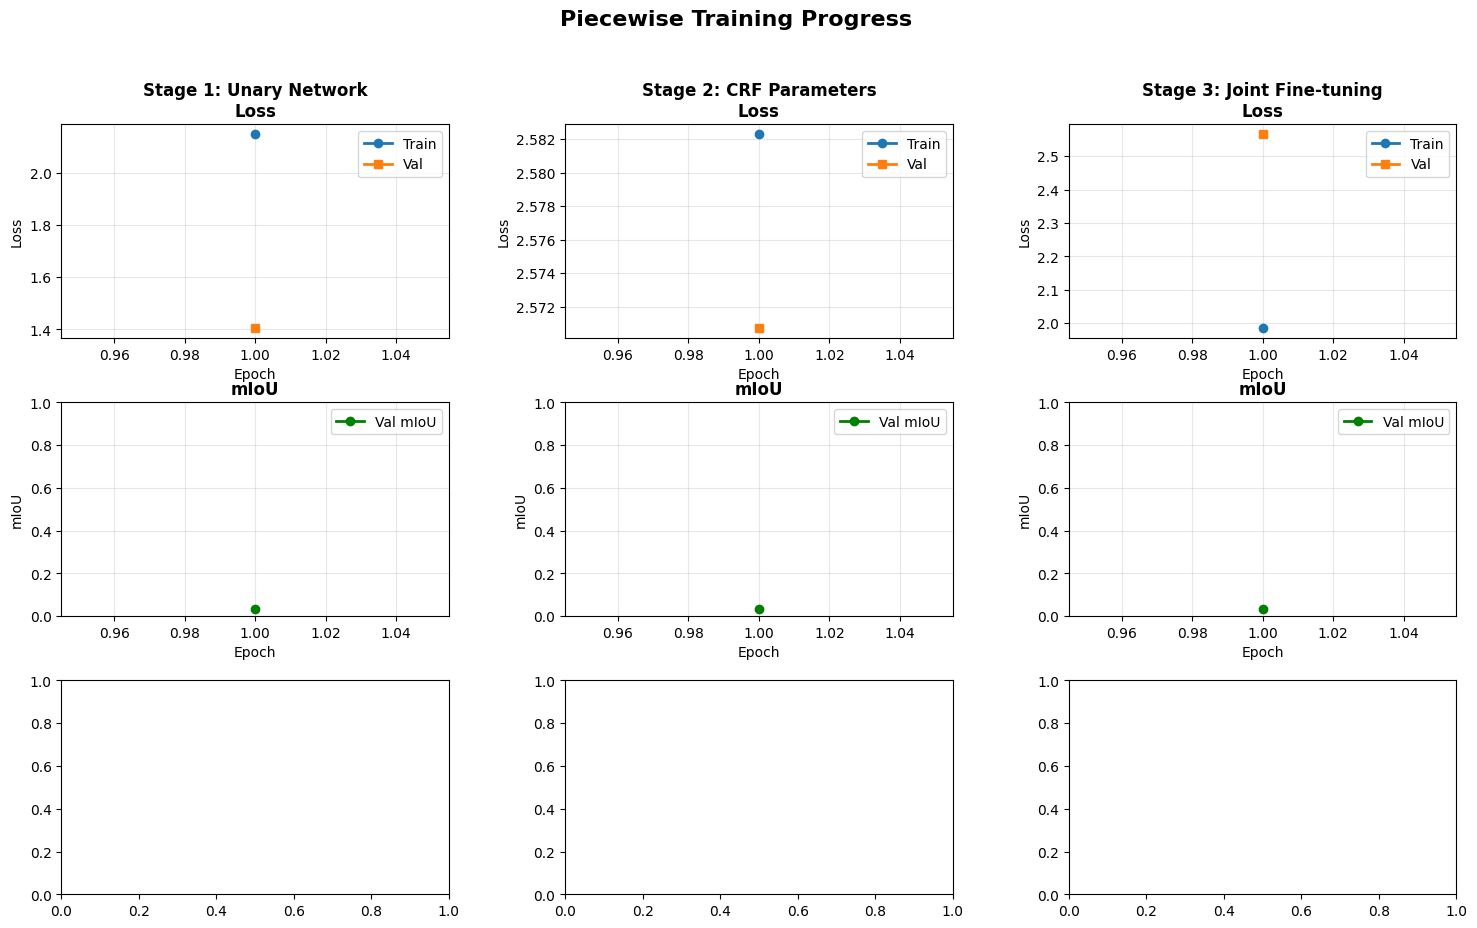


📋 Metrics Summary:

TRAINING METRICS SUMMARY
+------------+--------------+------------+------------+----------+-------------+
| Stage      |   Train Loss |   Val Loss |   Val mIoU |     mIoU |   Pixel Acc |
+============+==============+============+============+==========+=============+
| Stage 1    |       2.1482 |     1.4038 |     0.0348 | nan      |    nan      |
+------------+--------------+------------+------------+----------+-------------+
| Stage 2    |       2.5823 |     2.5707 |     0.0348 | nan      |    nan      |
+------------+--------------+------------+------------+----------+-------------+
| Stage 3    |       1.9837 |     2.5665 |     0.0348 | nan      |    nan      |
+------------+--------------+------------+------------+----------+-------------+
| Final Test |     nan      |   nan      |   nan      |   0.0348 |      0.7318 |
+------------+--------------+------------+------------+----------+-------------+


🔢 Confusion Matrix:


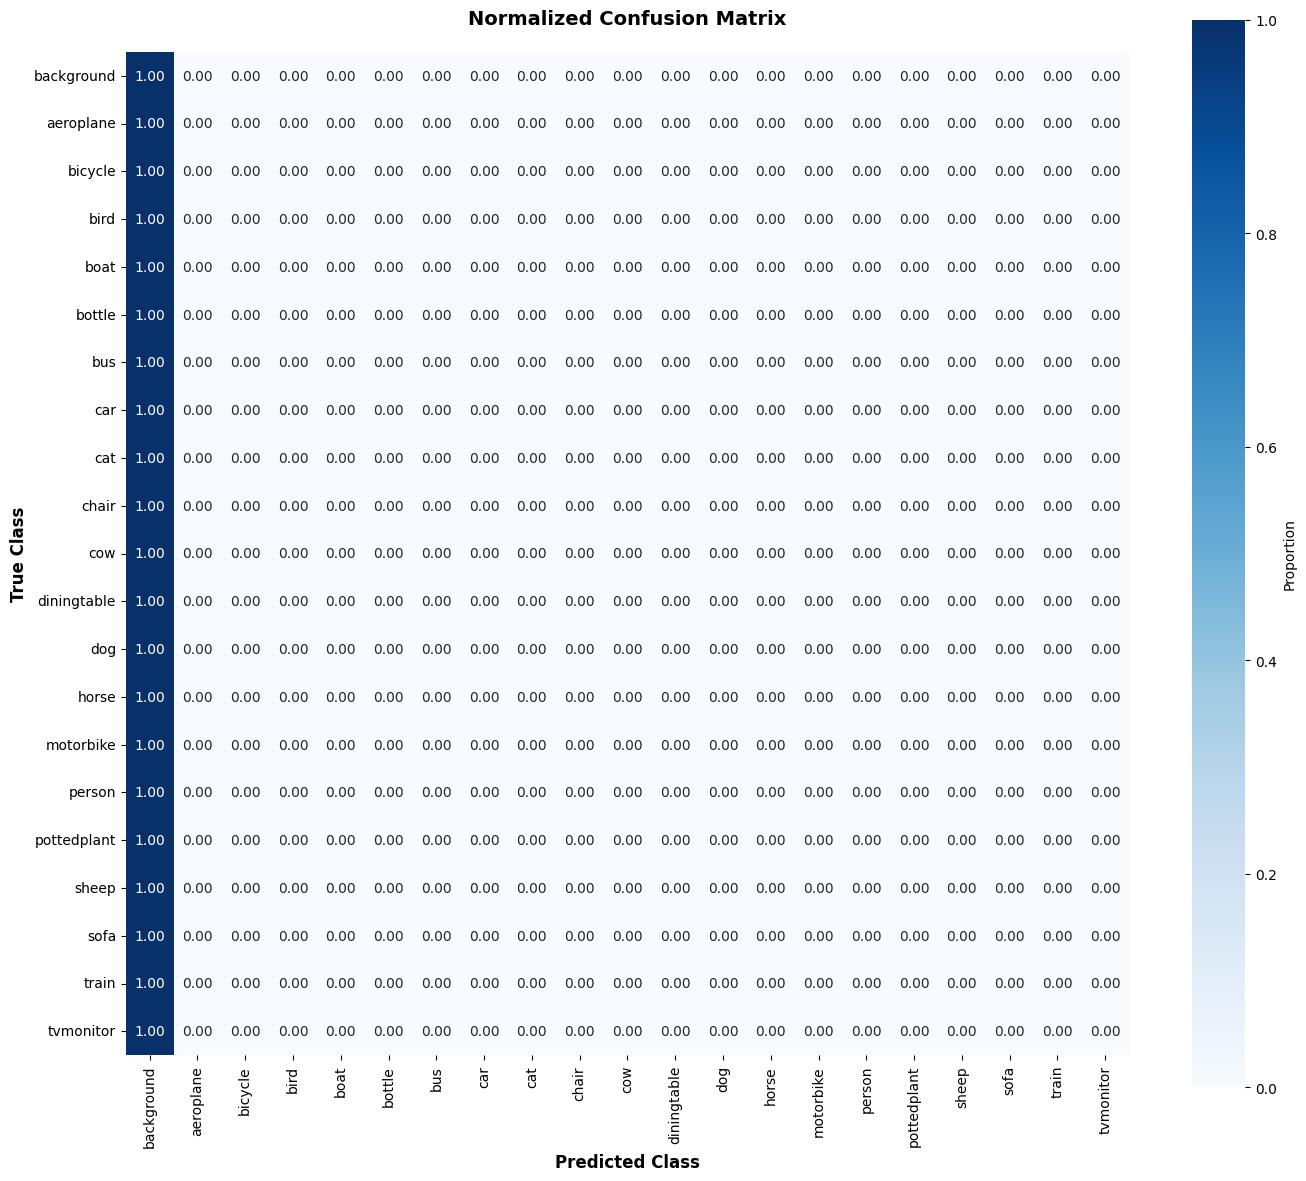


📊 Per-Class IoU:


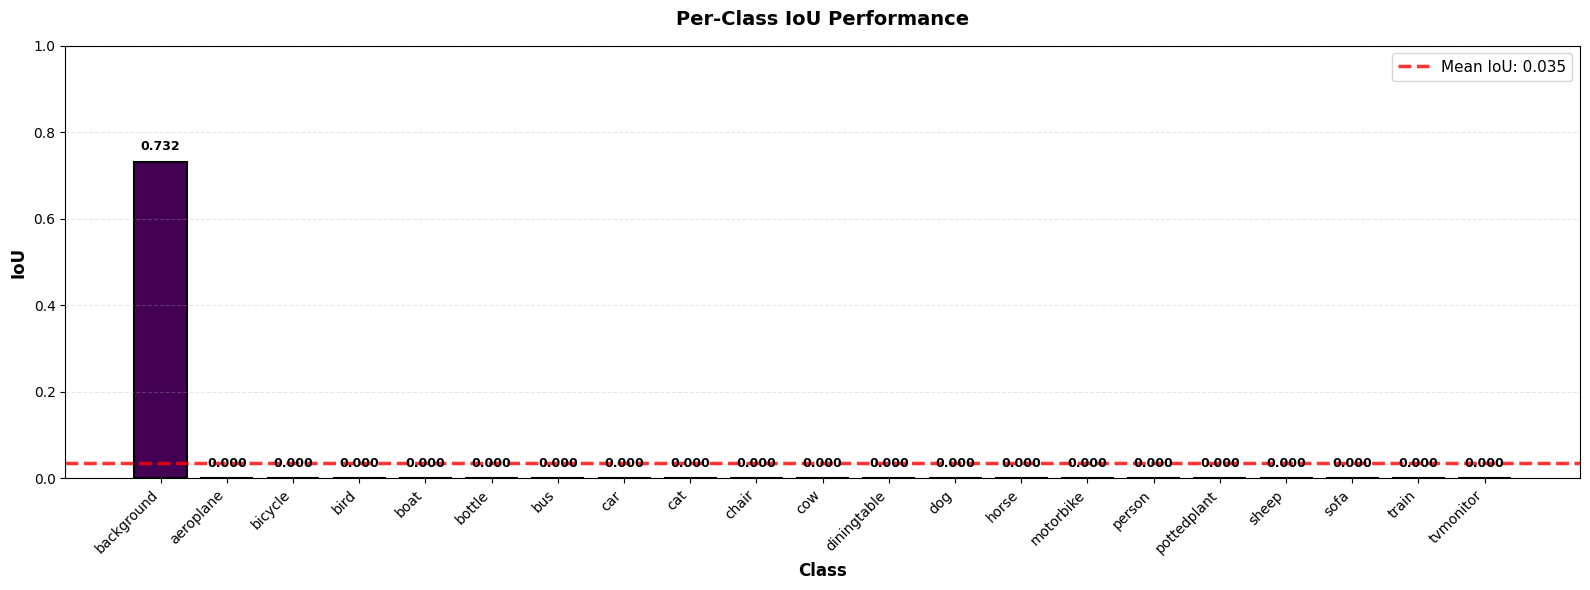


🖼️ Sample Predictions:


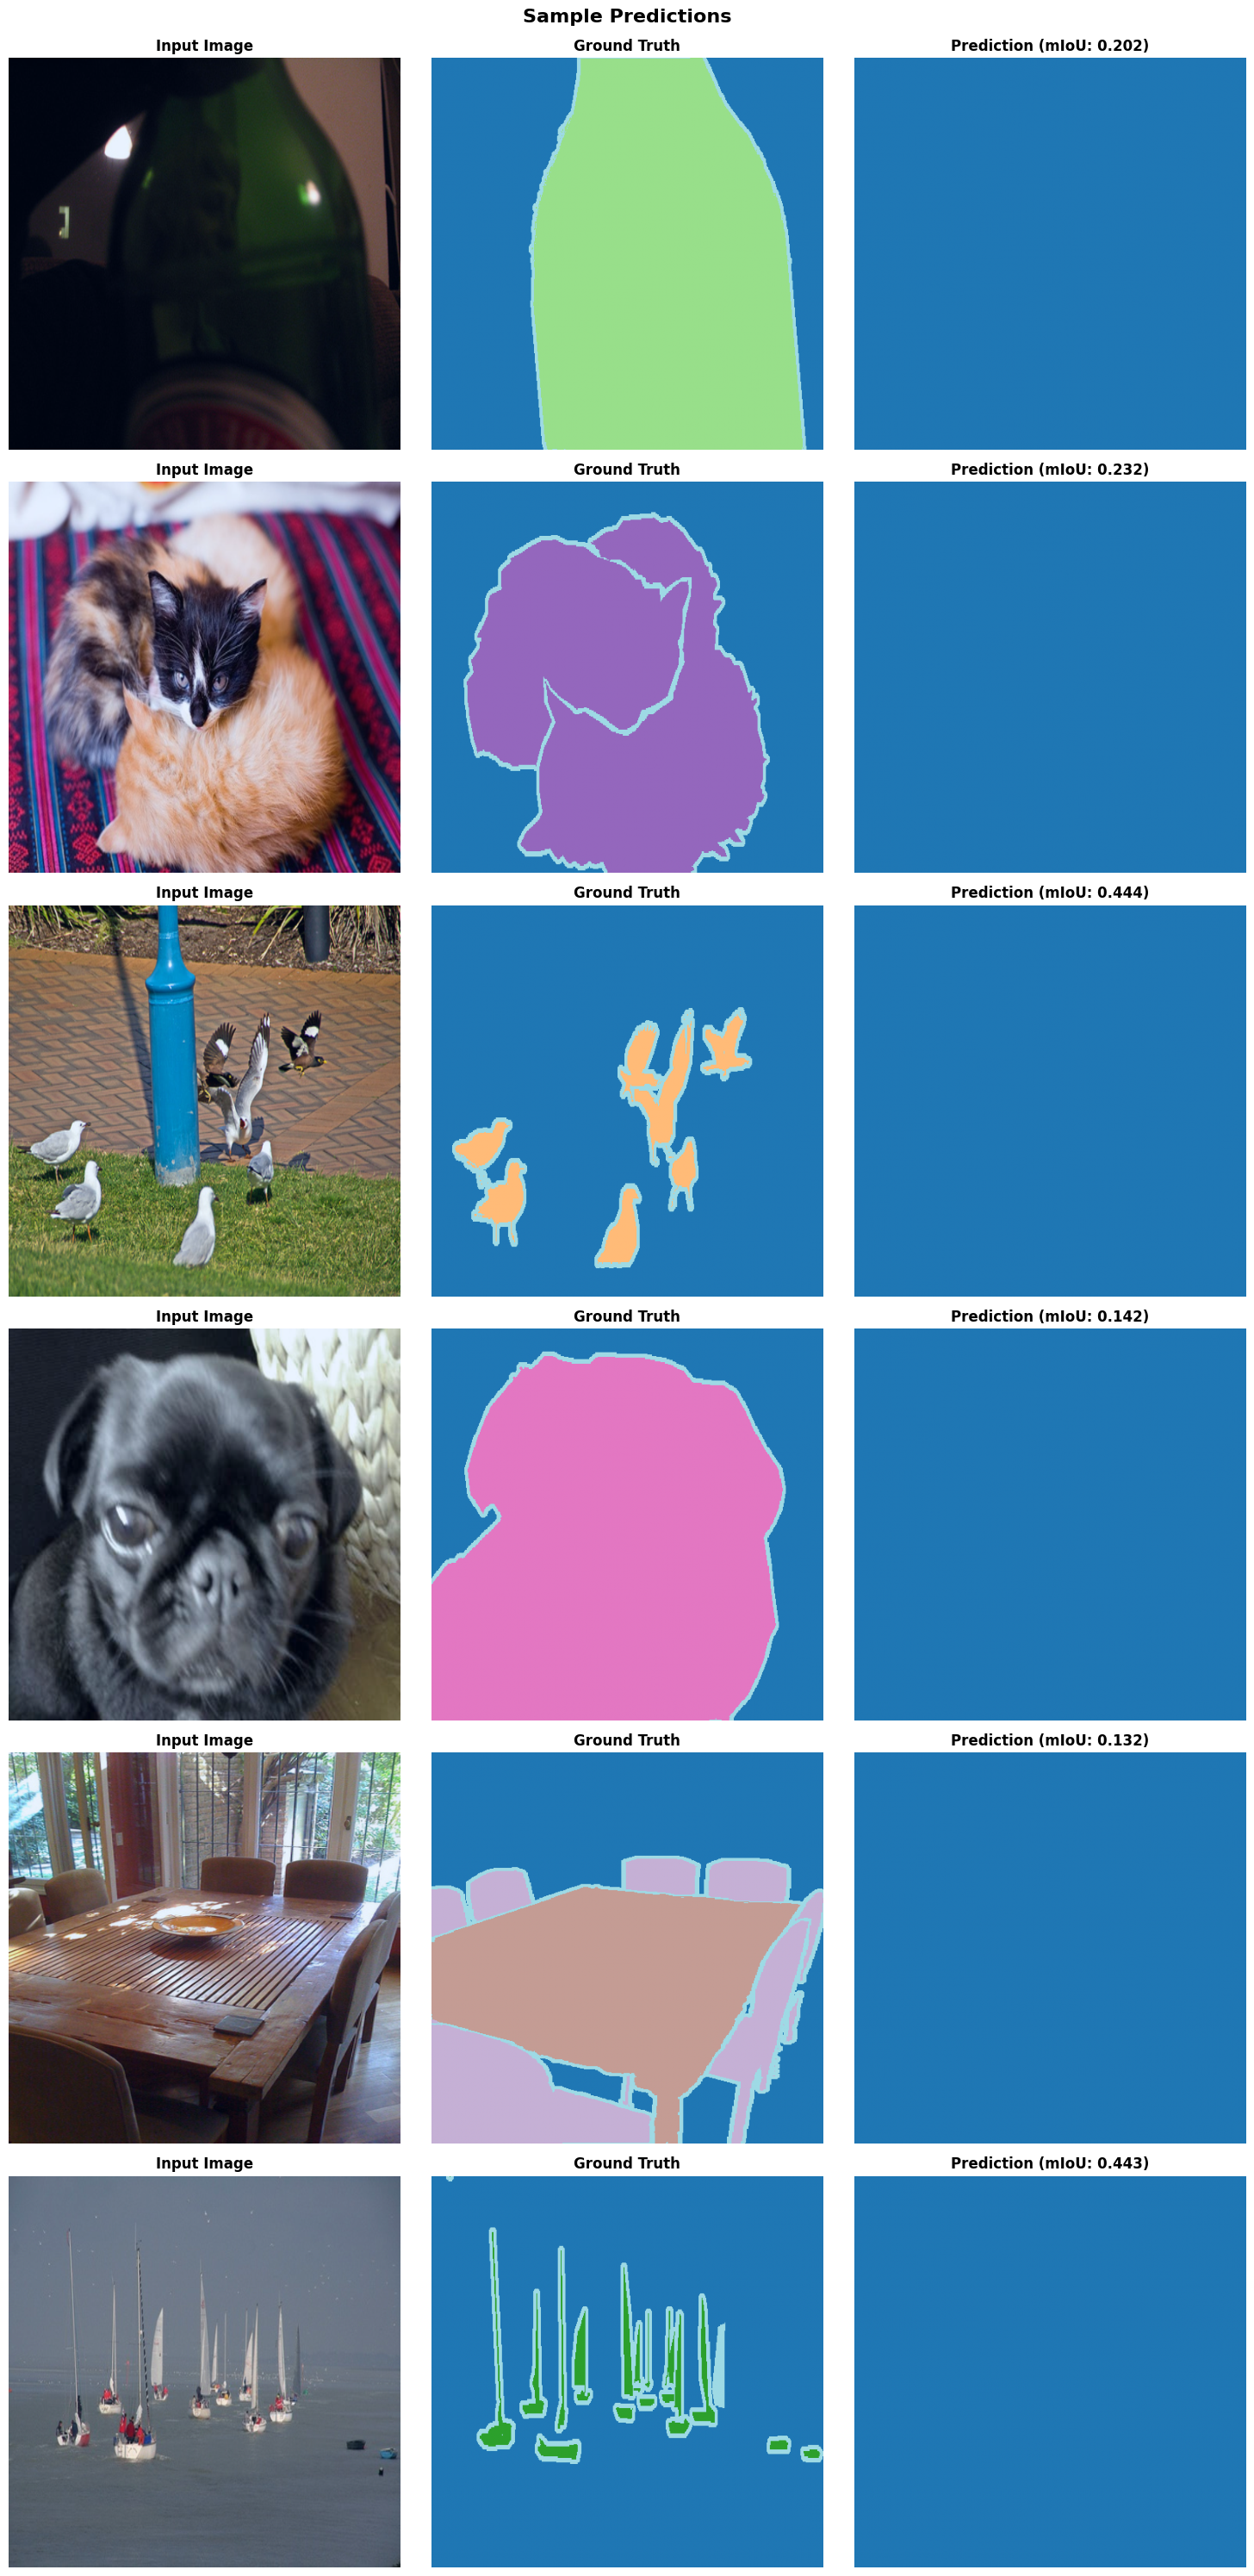


🔍 CRF Refinement Comparison:


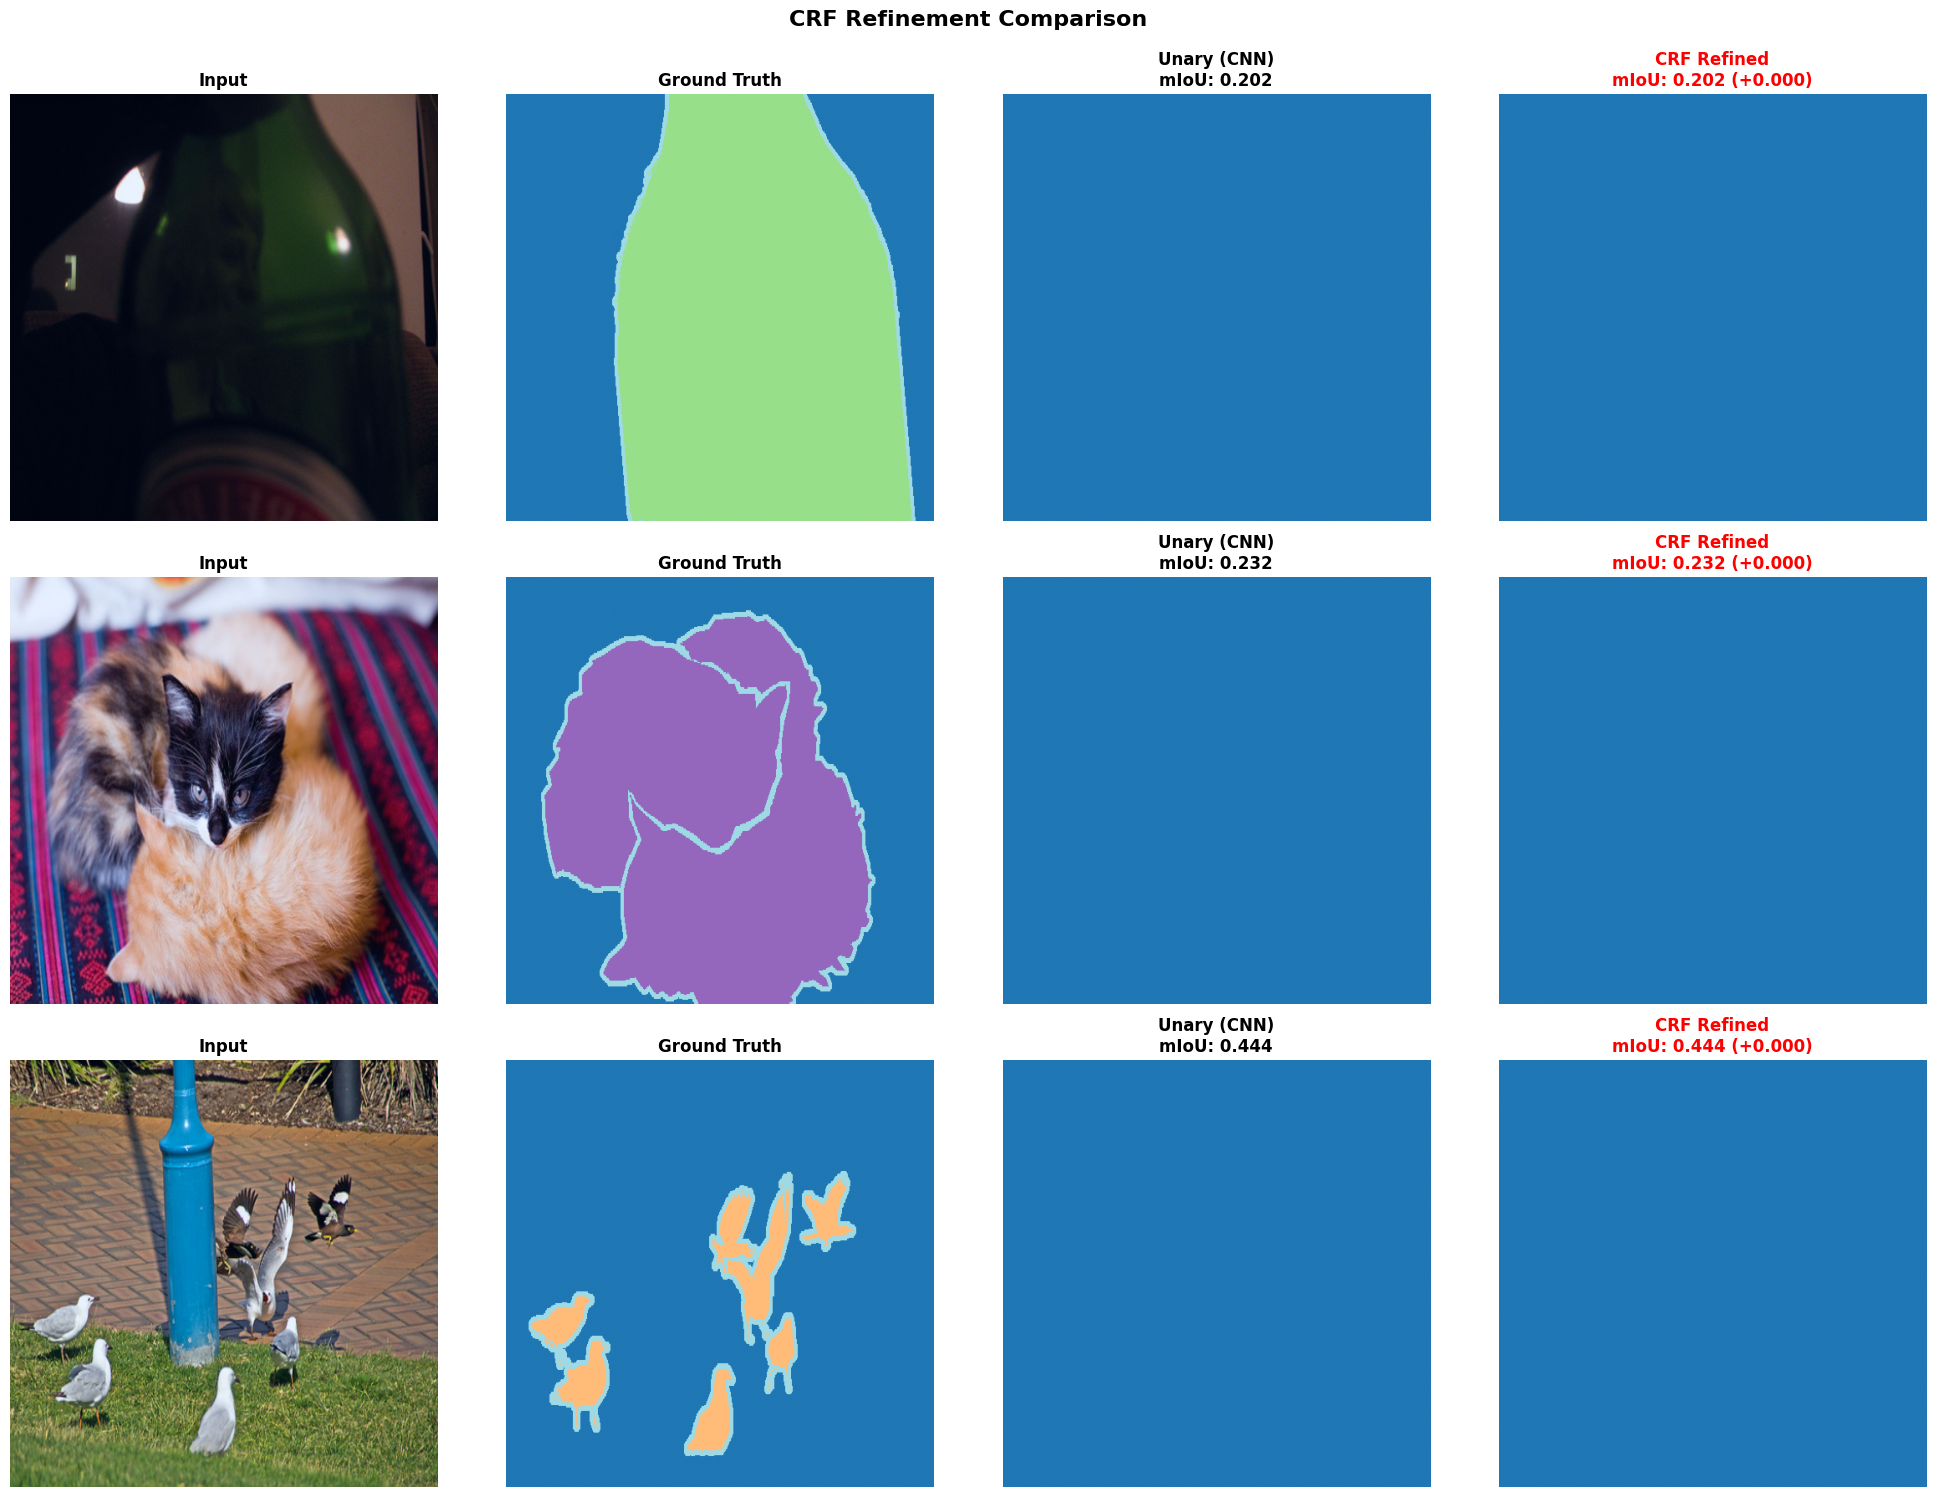

In [16]:
# 8.1 Training Curves
print("\n📊 Training Curves:")
visualizer.plot_training_curves(history)

# 8.2 Metrics Table
print("\n📋 Metrics Summary:")
visualizer.generate_metrics_table(history, final_metrics)

# 8.3 Confusion Matrix
print("\n🔢 Confusion Matrix:")
visualizer.plot_confusion_matrix(confusion_matrix)

# 8.4 Per-Class IoU
print("\n📊 Per-Class IoU:")
visualizer.plot_per_class_iou(iou_per_class)

# 8.5 Sample Predictions
print("\n🖼️ Sample Predictions:")
visualizer.visualize_predictions_grid(sample_predictions[:6])

# 8.6 CRF Comparison
print("\n🔍 CRF Refinement Comparison:")
visualizer.plot_crf_comparison(sample_predictions[:3])

## 9. Detailed Per-Class Performance Analysis

In [17]:
print("\n" + "="*70)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("="*70)

# Create detailed table
import pandas as pd
from tabulate import tabulate

class_performance = []
for idx, class_name in enumerate(PASCAL_VOC_CLASSES):
    if not np.isnan(iou_per_class[idx]):
        tp = confusion_matrix[idx, idx]
        fp = confusion_matrix[:, idx].sum() - tp
        fn = confusion_matrix[idx, :].sum() - tp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        class_performance.append({
            'Class': class_name,
            'IoU': iou_per_class[idx],
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': int(tp + fn)
        })

df_performance = pd.DataFrame(class_performance)
df_performance = df_performance.sort_values('IoU', ascending=False)

print(tabulate(df_performance, headers='keys', tablefmt='grid', floatfmt='.4f', showindex=False))

# Save to CSV
df_performance.to_csv(f'{results_dir}/per_class_performance.csv', index=False)
print(f"\n✅ Saved to: {results_dir}/per_class_performance.csv")


PER-CLASS PERFORMANCE ANALYSIS
+-------------+--------+-------------+----------+------------+-----------+
| Class       |    IoU |   Precision |   Recall |   F1-Score |   Support |
+=============+========+=============+==========+============+===========+
| background  | 0.7318 |      0.7318 |   1.0000 |     0.8452 | 105834356 |
+-------------+--------+-------------+----------+------------+-----------+
| aeroplane   | 0.0000 |      0.0000 |   0.0000 |     0.0000 |   1110745 |
+-------------+--------+-------------+----------+------------+-----------+
| bicycle     | 0.0000 |      0.0000 |   0.0000 |     0.0000 |    384128 |
+-------------+--------+-------------+----------+------------+-----------+
| bird        | 0.0000 |      0.0000 |   0.0000 |     0.0000 |   1698569 |
+-------------+--------+-------------+----------+------------+-----------+
| boat        | 0.0000 |      0.0000 |   0.0000 |     0.0000 |    799890 |
+-------------+--------+-------------+----------+------------+------

## 10. Run Inference on Test Images


RUNNING INFERENCE ON TEST IMAGES

🖼️ Running inference on: 2007_002914.jpg


C:\Users\rkekanaje\AppData\Local\Temp\ipykernel_33088\1268625827.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


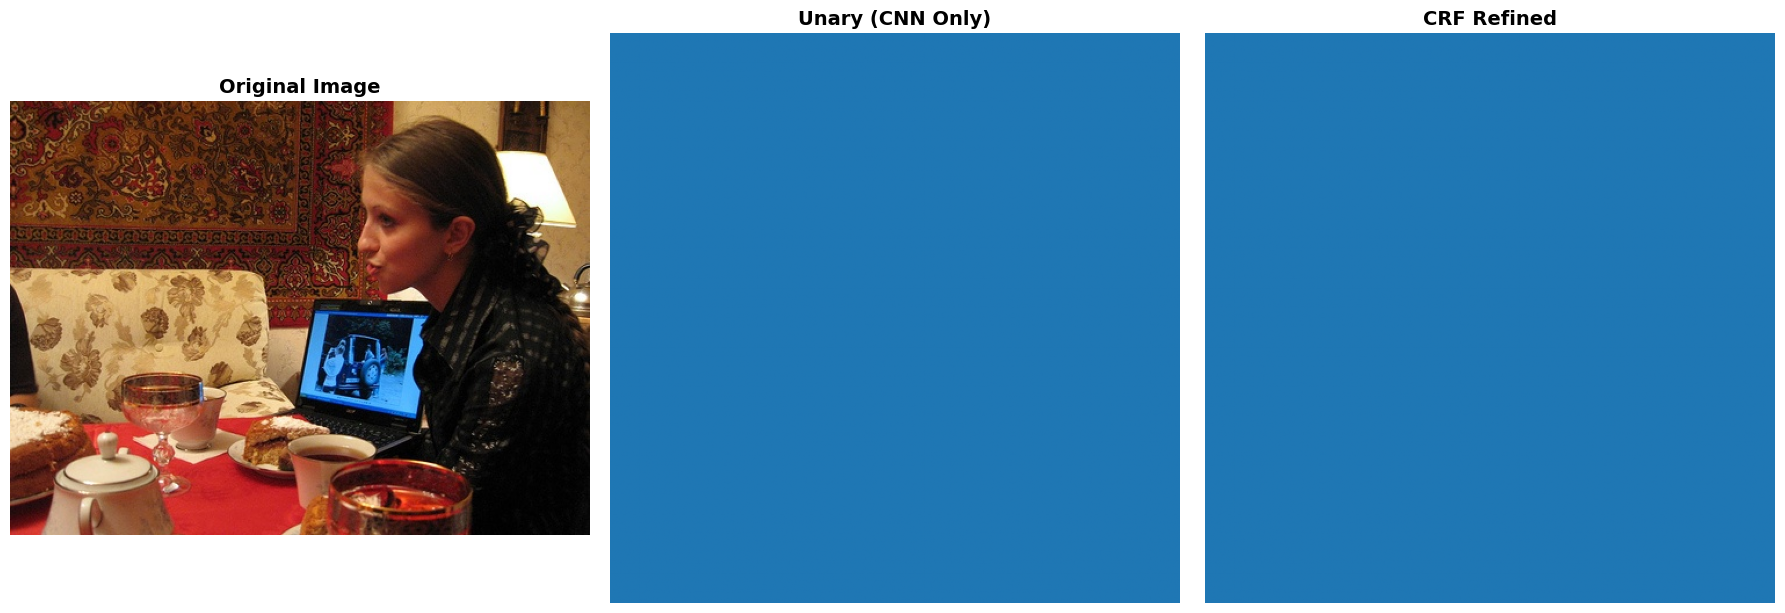

✅ Inference complete!


In [18]:
print("\n" + "="*70)
print("RUNNING INFERENCE ON TEST IMAGES")
print("="*70)

def run_inference_on_image(image_path, model, device, visualize=True):
    """Run inference on a single image."""
    from torchvision import transforms
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    original_size = image.size
    
    # Resize and normalize
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Run inference
    model.eval()
    with torch.no_grad():
        unary_output, crf_output = model(image_tensor, apply_crf=True)
        
        unary_pred = unary_output.argmax(1).squeeze(0)
        crf_pred = crf_output.argmax(1).squeeze(0) if crf_output is not None else unary_pred
    
    if visualize:
        # Visualize results
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image
        axes[0].imshow(image)
        axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        # Unary prediction
        colors = plt.cm.get_cmap('tab20', num_classes)
        unary_colored = colors(unary_pred.cpu().numpy())[:, :, :3]
        axes[1].imshow(unary_colored)
        axes[1].set_title('Unary (CNN Only)', fontsize=14, fontweight='bold')
        axes[1].axis('off')
        
        # CRF prediction
        crf_colored = colors(crf_pred.cpu().numpy())[:, :, :3]
        axes[2].imshow(crf_colored)
        axes[2].set_title('CRF Refined', fontsize=14, fontweight='bold')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return unary_pred, crf_pred


# Example: Run inference on a random validation image
sample_label_files = [f for f in os.listdir(label_dir) if f.endswith('.png')]
if len(sample_label_files) > 0:
    test_label = random.choice(sample_label_files)
    test_image_name = test_label.replace('.png', '.jpg')
    test_image_path = os.path.join(image_dir, test_image_name)
    
    if os.path.exists(test_image_path):
        print(f"\n🖼️ Running inference on: {test_image_name}")
        unary_pred, crf_pred = run_inference_on_image(test_image_path, model, device)
        print("✅ Inference complete!")

## 11. Batch Inference on Multiple Images

In [ ]:

def batch_inference(image_paths, model, device, save_dir='inference_results'):
    """Run inference on multiple images and save results."""
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    for idx, img_path in enumerate(image_paths):
        print(f"\nProcessing {idx+1}/{len(image_paths)}: {img_path}")
        
        unary_pred, crf_pred = run_inference_on_image(
            img_path, model, device, visualize=False
        )
        
        # Save predictions
        save_path = Path(save_dir) / f"prediction_{idx:03d}.png"
        
        # Convert to color image
        colors = plt.cm.get_cmap('tab20', num_classes)
        crf_colored = (colors(crf_pred.cpu().numpy())[:, :, :3] * 255).astype(np.uint8)
        Image.fromarray(crf_colored).save(save_path)
        
        print(f"   Saved to: {save_path}")

# Example: Process multiple test images
test_images = [
    '/path/to/test/image1.jpg',
    '/path/to/test/image2.jpg',
    '/path/to/test/image3.jpg',
]

# Uncomment to run batch inference
# batch_inference(test_images, model, device)

## 12. Summary and Next Steps

In [ ]:
print("\n" + "="*70)
print("TRAINING COMPLETE - SUMMARY")
print("="*70)

print(f"""
✅ Model trained successfully with piecewise strategy
✅ Final mIoU: {mean_iou:.4f}
✅ Pixel Accuracy: {final_metrics['Pixel Acc']:.4f}

📁 Generated Files:
   - Model: {model_save_path}
   - Results: {results_dir}/
     ├── training_curves.png
     ├── metrics_summary.txt
     ├── metrics_summary.csv
     ├── confusion_matrix.png
     ├── per_class_iou.png
     ├── sample_predictions.png
     ├── crf_comparison.png
     └── per_class_performance.csv

🎯 Next Steps:
   1. Review training curves and metrics
   2. Analyze per-class performance
   3. Run inference on your own images
   4. Fine-tune hyperparameters if needed
   5. Experiment with different CRF iterations
""")

print("="*70)